# Validation set scores for stocks with 15000 data points

In this notebook we present results for stocks with 15000 data points on validation sets. We also present the choosen methodology for choosing the best SVM kernel with tunned hyperparameters for each stock.

The order is as follows:
1. [Data preparation](#Data-preparation)
2. [Methodology](#Methodology)
3. [Results on validation set](#Results-on-validation-set)
4. [Conclusions](#Conclusions)

In [1]:
%matplotlib inline
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lob_data_utils.roc_results import results_15000 as results
from lob_data_utils import lob
from lob_data_utils import db_result

## Data preparation

Data frame `df` contains parameters and results from svm calculations for data length 15000 on validation set:

* `c` - C parameter for svm kernel - it's used by ****linear****, ****rbf**** and ****sigmoid**** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by ****rbf**** and ****sigmoid**** kernels, for **linear** it's set to $-1$.
* `coef0` - coef0 parameter for ****sigmoid**** kernel only - for other kernels it's set to -1.
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from 15000 data point data set
* `log_res` - result for logistic regression for 15000 data points
* `log_diff` - difference between `roc_auc_score` and `log_res`

In [2]:
result = db_result.get_svm_results_for_data_length(15000, 'cv')

df = pd.DataFrame(result)
print('Data length: ', len(df))
df.drop('algorithm_id', axis=1, inplace=True)
df.drop('svm_id', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.drop('data_type', axis=1, inplace=True)
df.drop('data_length', axis=1, inplace=True)

Data length:  7007


In [3]:
log_res = []
for i, row in df.iterrows():
    log_res.append(results.get(row['stock']))
df['log_res'] = log_res
df['log_diff'] = df['roc_auc_score'] - log_res
df.head()

,c,coef0,gamma,kernel,roc_auc_score,stock,log_res,log_diff
0,0.0001,0.0000,0.0001,sigmoid,0.5,9069,0.536706,-0.036706
1,0.0001,0.0001,0.0001,sigmoid,0.5,9069,0.536706,-0.036706
2,0.0001,0.0010,0.0001,sigmoid,0.5,9069,0.536706,-0.036706
3,0.0001,1.0000,0.0001,sigmoid,0.5,9069,0.536706,-0.036706
4,0.0001,10.0000,0.0001,sigmoid,0.5,9069,0.536706,-0.036706


#### Description of `df_bests`

In this data set we aggregate calculations with the best score by stock. It has the same fields as `df`.

* `c` - C parameter for svm kernel - it's used by ****linear****, ****rbf**** and ****sigmoid**** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by ****rbf**** and ****sigmoid**** kernels, for **linear** it's set to $-1$
* `coef0` - coef0 parameter for ****sigmoid**** kernel only - for other kernels it's set to -1
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from 15000 points dataset
* `log_res` - result for logistic regression for data with 15000 data points
* `log_diff` - difference between `roc_auc_score` and `log_res`

In [4]:
bests = []
df_best_agg = df.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests = df.loc[df_best_agg]
df_bests.index = df_bests['stock']
df_bests.sort_values(by='roc_auc_score', inplace=True)
df_bests.head()

,c,coef0,gamma,kernel,roc_auc_score,stock,log_res,log_diff
stock,,,,,,,,
9062,1.0,0.0,-1.0000,linear,0.521585,9062,0.522461,-0.000877
12059,500.0,0.0,0.0050,rbf,0.534971,12059,0.530526,0.004444
11244,500.0,0.0,50.0000,rbf,0.538229,11244,0.528181,0.010048
9064,5.0,0.0,5.0000,rbf,0.542943,9064,0.535298,0.007644
9069,500.0,0.0,0.0005,rbf,0.546392,9069,0.536706,0.009687


## Methodology 

For each stock we distinguished 3 continous sets of data points:

* training set (60% of data)
* validation set (20% of data)
* test set (20% of data)

We train our models on training set. We use validation sets for tunning the hyperparameters. In this notebook we don't use test set - there is a separate one for showing results on test sets.

### SVM parameters

We used parameters:

* $ \gamma $ from [0.0001, 0.0005, 0.001, 0.005, 1, 5, 10, 50, 100, 500, 1000, 5000]
* $ C $ from  [0.0001, 0.0005, 001, 0.005, 1, 5.0, 10, 50, 100, 500, 1000] (no 5000, too many iterations)
* $ coef0 $ from [0, 0.0001, 0.0005, 0.001, 0.005, 1, 5, 10, 50, 100, 500, 1000, 5000]
* kernel from [****linear****, ****rbf****, ****sigmoid****]

We calculated SVMs for different kernels with combinations of above parameters.

### Best kernel counts

We can see that ****linear**** kernel is not among the best choices. Kernel ****rbf**** is the most popular, but ****sigmoid**** also should be taken into account.

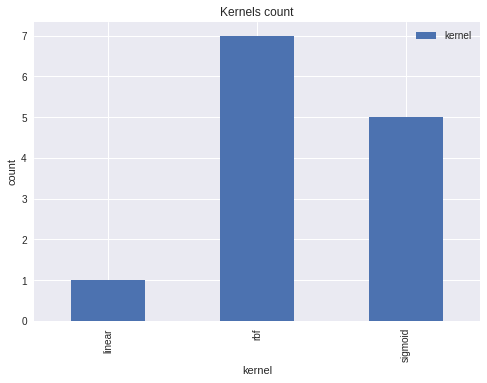

In [5]:
df_bests.groupby(['kernel'])[['kernel']].count().plot(kind='bar')
plt.title('Kernels count')
plt.ylabel('count')
plt.xlabel('kernel')

#### **RBF** kernel parameters

There is no rule about paramters - it seems that there are used 23 different sets of parameters for 31 best kernels.

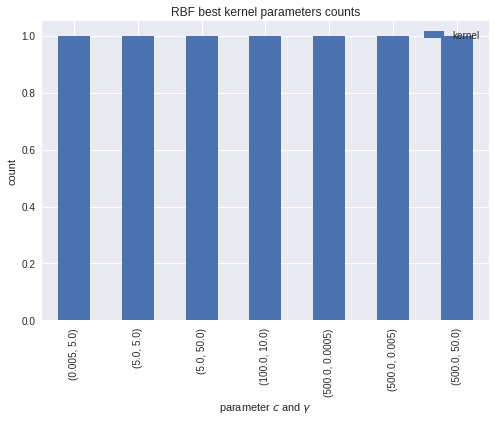

In [6]:
df_bests[df_bests['kernel'] == 'rbf'].groupby(['c', 'gamma'])[['kernel']].count().plot(kind='bar')
plt.title('RBF best kernel parameters counts')
plt.ylabel('count')
plt.xlabel('parameter $c$ and $\gamma$')

#### **sigmoid** kernel parameters

There is no rule about paramters - it seems that there are used 14 different sets of parameters for 22 best kernels.

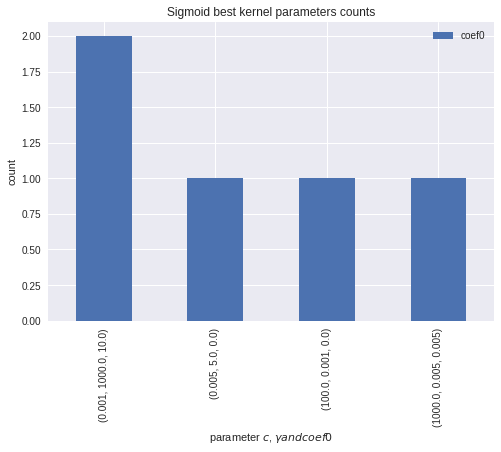

In [7]:
df_bests[df_bests['kernel'] == 'sigmoid'].groupby(['c', 'gamma', 'coef0'])[['coef0']].count().plot(
    kind='bar')
plt.title('Sigmoid best kernel parameters counts')
plt.ylabel('count')
plt.xlabel('parameter $c$, $\gamma and coef0 $')

## Results on validation set

Below we present results comparing SVM against null hyposthesis and then to previous solution - logistic regression on validation set.

### SVM vs null hypothesis

We can see that we are always better than null hypothesis (which has 0.5 roc area score). We are about 3%-9% better than null hyposthesis. Most common difference is between 6-8%.

min:  0.521584684274 max: 0.56894793105


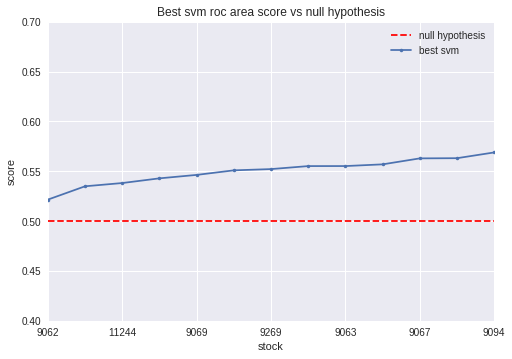

In [8]:
stocks = df_bests['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests['roc_auc_score'].plot(marker='.', label='best svm')
print('min: ', df_bests['roc_auc_score'].min(), 'max:',  df_bests['roc_auc_score'].max())
plt.ylabel('score')
plt.xlabel('stock')
plt.legend()
plt.ylim(0.4, 0.7)
plt.title('Best svm roc area score vs null hypothesis')

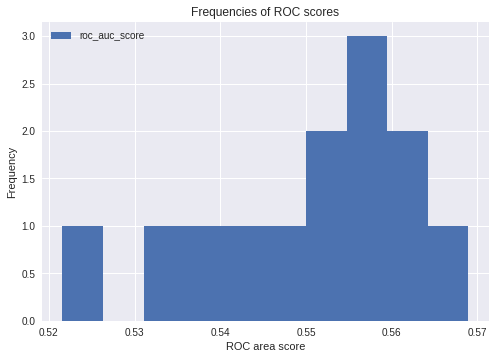

In [9]:
df_bests['roc_auc_score'].plot('hist')
plt.xlabel('ROC area score')
plt.legend()
plt.title('Frequencies of ROC scores')

### SVM vs logistic regression on validation set

We are always better than logistic regression. We can see that sometimes difference between scores isn't very big. Usually we are better not more than 0.5%, but for rare cases we can do better by 2%.

In [10]:
print('Number of better SVMs:', 
      len(df[df['log_res'] < df['roc_auc_score']]['stock'].unique()), 'per', len(df['stock'].unique()))

Number of better SVMs: 12 per 13


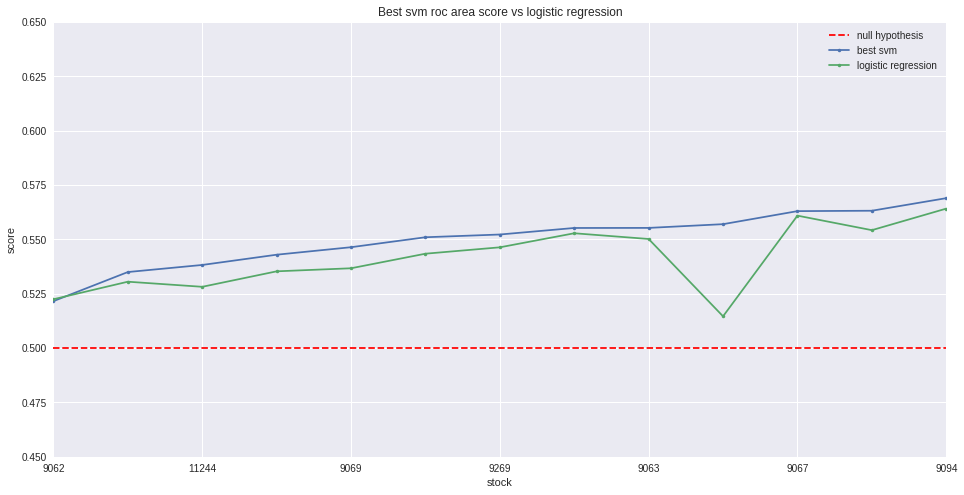

In [11]:
stocks = df_bests['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests['roc_auc_score'].plot(marker='.', label='best svm', figsize=(16, 8))
df_bests['log_res'].plot(marker='.', label='logistic regression')

plt.ylabel('score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best svm roc area score vs logistic regression')

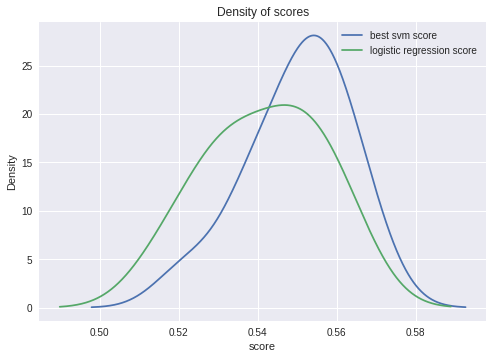

In [12]:
df_bests['roc_auc_score'].plot('kde', label='best svm score')
df_bests['log_res'].plot('kde', label='logistic regression score')
plt.title('Density of scores')
plt.xlabel('score')
plt.legend()

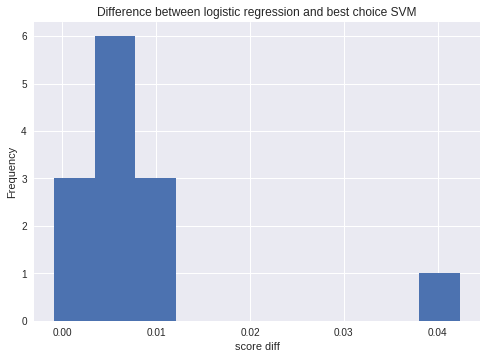

In [13]:
df_bests['log_diff'].plot(kind='hist')
plt.title('Difference between logistic regression and best choice SVM')
plt.xlabel('score diff')

### Results by kernel

To present results by kernel in `df_bests_by_kernels` we aggregate results on validation set by kernel. 
In `df_kernels` we put `roc_auc_score` results for each stock.

In [14]:
df_best_agg = df.groupby(['stock', 'kernel'], as_index=True)['roc_auc_score'].idxmax()
df_bests_by_kernels = df.loc[df_best_agg]
df_bests_by_kernels.head(9)

,c,coef0,gamma,kernel,roc_auc_score,stock,log_res,log_diff
881,1.000,0.0,-1.000,linear,0.558752,10166,0.554231,0.004520
4180,5.000,0.0,0.005,rbf,0.559108,10166,0.554231,0.004877
828,0.001,10.0,1000.000,sigmoid,0.563167,10166,0.554231,0.008936
5046,0.005,0.0,-1.000,linear,0.527637,11244,0.528181,-0.000545
5176,500.000,0.0,50.000,rbf,0.538229,11244,0.528181,0.010048
5042,0.005,50.0,5000.000,sigmoid,0.535557,11244,0.528181,0.007376
3086,1.000,0.0,-1.000,linear,0.530443,12059,0.530526,-0.000084
6924,500.000,0.0,0.005,rbf,0.534971,12059,0.530526,0.004444
3016,0.001,1.0,10.000,sigmoid,0.532832,12059,0.530526,0.002306


In [15]:
df_kernels = df_bests_by_kernels.pivot(index='stock', columns='kernel', values='roc_auc_score')
df_kernels.sort_index(inplace=True)
df_kernels.head()

kernel,linear,rbf,sigmoid
stock,,,
10166,0.558752,0.559108,0.563167
11244,0.527637,0.538229,0.535557
12059,0.530443,0.534971,0.532832
9058,0.547244,0.550972,0.550472
9061,0.554555,0.556970,0.556986


##### Kernel comparision

From the plot below we can see than ****sigmoid**** kernel has the most high score results, but only on certain stocks (look at highest spikes). The ****linear**** kernel is usually the worst one (except one case).

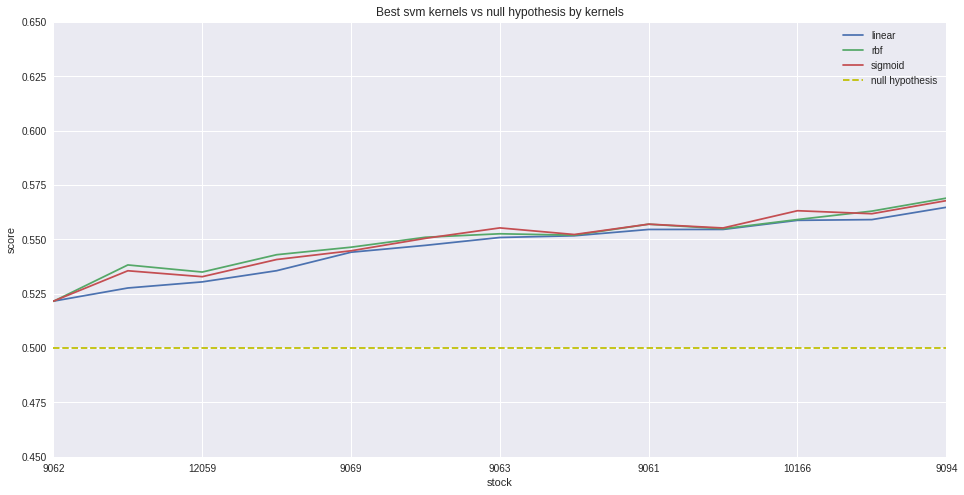

In [16]:
df_kernels.sort_values(by=['linear', 'sigmoid', 'rbf']).plot(figsize=(16, 8))
plt.plot(np.zeros(len(df_kernels)) + 0.5, 'y--', label='null hypothesis')
plt.ylabel('score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best svm kernels vs null hypothesis by kernels')

##### SVM **linear** kernel vs logistic regression

They are almost the same - in most cases SVM with **linear** kernel performs slightly better, but not more than 1%.

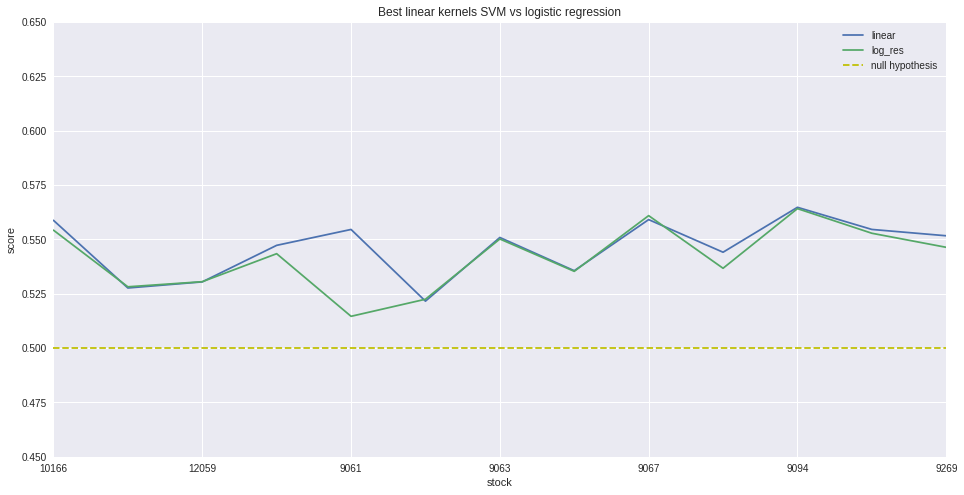

In [17]:
df_bests.sort_index(inplace=True)
df_kernels['linear'].plot(figsize=(16,8))
df_bests['log_res'].plot()
plt.plot(np.zeros(len(df_kernels)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best linear kernels SVM vs logistic regression')

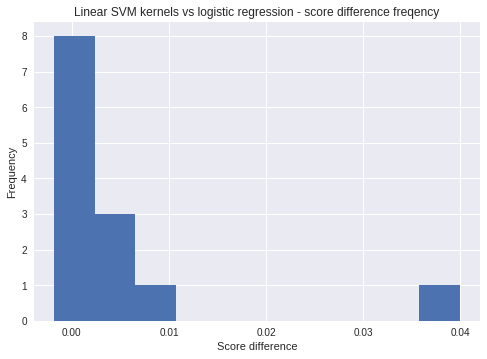

In [18]:
(df_kernels['linear'] - df_bests['log_res']).plot(kind='hist')
plt.xlabel('Score difference')
plt.title('Linear SVM kernels vs logistic regression - score difference freqency')

##### SVM **rbf** kernel vs logistic regression

SVM with **rbf** performs always better than logistic regression - for a single cases it can be better by 2%, but most usually the difference is less than 1%.

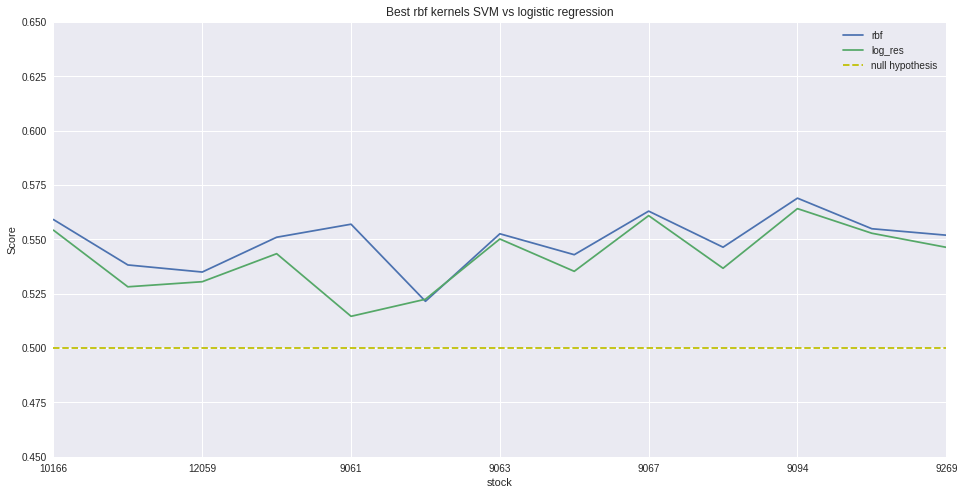

In [19]:
df_bests.sort_index(inplace=True)
df_kernels['rbf'].plot(figsize=(16,8))
df_bests['log_res'].plot()
plt.plot(np.zeros(len(df_kernels)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best rbf kernels SVM vs logistic regression')

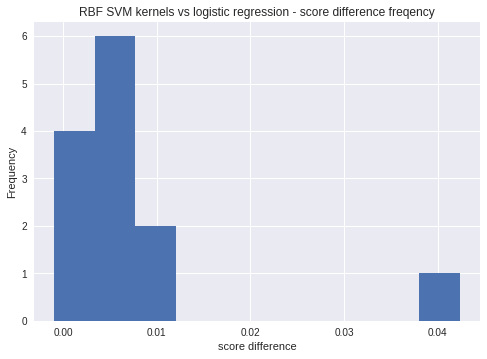

In [20]:
(df_kernels['rbf'] - df_bests['log_res']).plot(kind='hist')
plt.xlabel('score difference')
plt.title('RBF SVM kernels vs logistic regression - score difference freqency')

##### SVM **sigmoid** kernel vs logistic regression

SVM with **sigmoid** kernel usually performs better - it can be better by 2% than logistic regression in rare cases. It can also perfom worse in rare cases by 0.5%.

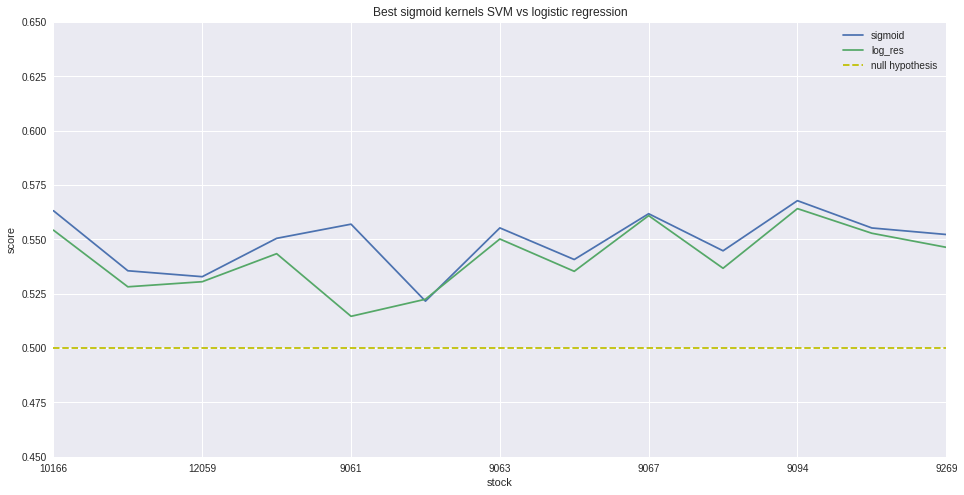

In [21]:
df_bests.sort_index(inplace=True)
df_kernels['sigmoid'].plot(figsize=(16,8))
df_bests['log_res'].plot()
plt.plot(np.zeros(len(df_kernels)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best sigmoid kernels SVM vs logistic regression')

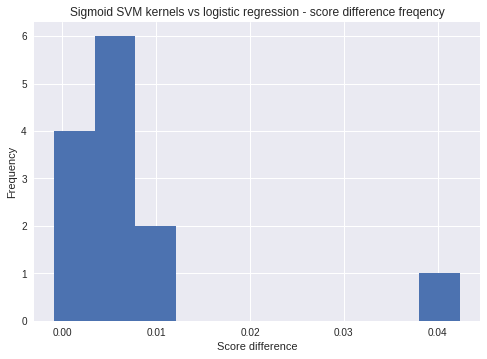

In [22]:
(df_kernels['sigmoid'] - df_bests['log_res']).plot(kind='hist')
plt.xlabel('Score difference')
plt.title('Sigmoid SVM kernels vs logistic regression - score difference freqency')

## Conclusions

After hyperparameter tunning on validation set we conclude:

* there is no one choice of parameters - they have to be tunned separately for each stock
* all SVM kernels after hyperparameter tunning perform better than null hyposthesis 3-9% better
* **rbf** kernel is always better than logistic regression
* **rbf** kernel usually performs better than other kernels
* **linear** kernel has very similar results to logistic regression
* **linear** kernel is always worse than **rbf** and **sigmoid**
* **sigmoid** kernel usually perfom better than logistic regression
* **sigmoid** kernel sometimes has the top score, which is much better than the rest kernels